# The `linearsolve` package

The `linearsolve` provides for the solution and simulation of dynamic linear models with forward-looking variables. In particular, this module produces a solution for models with the forms:

\begin{align}
A E_t\left[ x_{t+1} \right] & = B x_t + C z_t,
\end{align}

with $x_t = [k_t; u_t]$ and where $k_t$ is a vector of predetermined (state) variables and $u_t$ is a vector 
of nonpredetermined (forward-looking) variables. $z_t$ is a vector of exogenous driving variables with 
autocorrelation matrix $\rho$. The solution to the model is a set of matrices $f$, $n$, $p$, $l$ such that:

\begin{align}
u_t   = Fk_t + Nz_t\\
k_{t+1} = Pk_t + Lz_t.
\end{align}
    
The module makes use of the [Klein (2000)](http://www.sciencedirect.com/science/article/pii/S0165188999000457) solution method based on the generalized Schur factorization and incorporates many aspects of his program for Matlab [`solab.m`](http://paulklein.ca/newsite/codes/codes.php). I use the `cvxopt` package to perform the requisite Schur decomposition in the routine.

In this notebook, I demonstrate how to use the module to simulate two basic business cycle models.

In [1]:
import numpy as np
import linearsolve as ls
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Example 1: A real business cyle (RBC) model without labor

The equilibrium conditions for a basic RBC model with no labor are given by:

\begin{align}
C_t^{-\sigma} & = \beta E_t \left[C_{t+1}^{-\sigma}(\alpha A_{t+1} K_{t+1}^{\alpha-1} + 1 - \delta)\right]\\
C_t + K_{t+1} & = A_t K_t^{\alpha} + (1-\delta)K_t\\
\log A_t & = \rho_a \log A_{t-1} + \epsilon_t
\end{align}

In the nonstochastic steady state, we have:

\begin{align}
K & = \left(\frac{\alpha A}{1/\beta+\delta-1}\right)^{\frac{1}{1-\alpha}}\\
C & = AK^{\alpha} - \delta K
\end{align}

Given values for the parameters of the model, steady state values of capital and consumption are easily computed.

### The log-linearized model

The log-linear equilibrium conditions of the RBC model are:
\begin{align}
-\sigma \hat{c}_t & = -\sigma E_t\hat{c}_{t+1} + \alpha(\alpha - 1)\beta A K^{\alpha -1} \hat{k}_{t+1} + \alpha\beta A K^{\alpha -1} \rho_a\hat{a}_t\\
\frac{C}{K}\hat{c}_t + \hat{k}_{t+1} & = \left[\alpha A K^{\alpha -1} + 1-\delta \right] \hat{k}_t + A K^{\alpha -1}\hat{a}_t\\
\hat{a}_t & = \rho_a \hat{a}_{t-1} + \epsilon_t
\end{align}

### Writing the model in the required format

We need to write the model in the following form:

\begin{align}
A E_t\left[ x_{t+1} \right] & = B x_t + C Z_t,
\end{align}

with $X_t = [k_t; u_t]$ and where $k_t$ is a vector of predetermined (state) variables and $u_t$ is a vector 
of nonpredetermined (forward-looking) variables. So we need to determine what are the state variables and what are the forward-looking variables and then the contents of the matrices $A$, $B$, and $C$. Set $k_t = [\hat{k}_t, \hat{a}_{t-1}]'$ and $u_t = [\hat{c}_t]$ so that:

\begin{align}
x_t = \left[\begin{array} \hat{k}_t\\ \hat{a}_{t-1} \\ \hat{c}_t \end{array}\right]
\end{align}

and:

\begin{align}
z_t = \left[\epsilon_t\right]
\end{align}

Then the model is written as:

\begin{align}
\underbrace{\left[\begin{matrix}
\alpha \beta A K^{\alpha-1}\rho_a & \alpha(\alpha-1)\beta A K^{\alpha-1} & -\sigma \\
-A K^{\alpha-1} & 1 & 0 \\ 
1 & 0 & 0 
\end{matrix}\right]}_{A} 
\left[\begin{matrix} \hat{k}_{t+1}\\ \hat{a}_{t} \\ E_t\hat{c}_{t+1} \end{matrix}\right] & = \underbrace{\left[\begin{matrix}
0 & 0 & -\sigma \\ 
0 & \alpha A K^{\alpha-1} + 1 - \delta & -C/K \\
\rho_a & 0 & 0 \end{matrix}\right]}_{B} 
\left[\begin{matrix} \hat{k}_t\\ \hat{a}_{t-1} \\ \hat{c}_t \end{matrix}\right] + \underbrace{\left[\begin{matrix} 0 \\ 0 \\ 1 \end{matrix}\right]}_C \left[\epsilon_t\right] \end{align}

Now the model is in the form required by the solution method. Note that the program will return a solution for $a_{t-1}$ and so we'll have to account for this later. Or we could create another endogenous (forward-looking) variable $b_t = a_t$.

In [2]:
# Input model parameters
alpha = 0.65
beta = 0.99
delta  = 0.025
rhoa= 0.9
sigma= 1.5
A= 1

# Steady state solution
K = (alpha*A/(1/beta+delta-1))**(1/(1-alpha))
C = A*K**alpha - delta*K

# Input the matrix values for the solution
a11,a12,a13 = alpha*beta*A*K**(alpha-1)*rhoa, alpha*beta*(alpha-1)*A*K**(alpha-1), -sigma
a21,a22,a23 = -A*K**(alpha-1), 1, 0
a31,a32,a33 = 1, 0, 0

b11,b12,b13 = 0, 0, -sigma
b21,b22,b23 = 0, alpha*A*K**(alpha-1) + 1 - delta, -C/K
b31,b32,b33 = rhoa, 0, 0

c11 = 0
c21 = 0
c31 = 1

# Form the required matrices
a = [[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]]
b = [[b11, b12, b13], [b21, b22, b23], [b31, b32, b33]]
c = [[c11],[c21],[c31]]


# The exogenous shock process has no autocorrelation
rho = [[0.0]]

# The model has two predetermined variables
nk = 2

#Solve the model
model = ls.klein(a,b,c,rho,nk,endoNames=['k','a','c'],exoNames=['eA'])

### About the solution results

The `model` variable produced by the preceding command contains the solution matrices and other valuable information about the solution. The solution matrices $F$, $N$, $P$, $L$ are contained in the attributes `.f`, `.n`, `.p`, and `.l`.

In [3]:
print('f= ',model.f,'\n')
print('n= ',model.n,'\n')
print('p= ',model.p,'\n')
print('l= ',model.l,'\n')

f=  [[ 0.14020757  0.72806857]] 

n=  [[ 0.15578619]] 

p=  [[ 0.9         0.        ]
 [ 0.04453516  0.98898589]] 

l=  [[ 1.        ]
 [ 0.04948351]] 



The `model` variable also contains the eigenvalues from the generalized Schur decomposition in the attribut `.eig`. Exactly $n_k$ should be inside the unit circle. The program will warn if this condition is not satisfied.

In [4]:
print('Eigenvalues of the model: ',model.eig)

Eigenvalues of the model:  [ 0.98898589  0.9         1.02135027]


### Impulse responses

The module provides a method for constructing impulse responses called `.impulse()`. Use the method to construct simulated responses of all endogenous variables to a one-tim shock to *each* exogenous variable. Ppecify the number of periods to simulate `T`, the date at which the shock occurs `t0`, and the values of the shocks to the variables in a array-like variable called `shock`. If you do not supply a value for `shock`, then a value of 0.01 will be used by default.

`.impulse()` returns a dictionary attribute. The keys are the names of the exogenous shocks; either what you input above or 'shock 1', 'shock 2', etc. Each item in the dictionary is a Pandas dataframe that contains the impulse respones for the corresponding shock.

Recall from above that our solution is for $a_{t-1}$ instead of $a_{t}$. The module also has additional functions for shifting the simulation of a single variable -- `.shift()` -- and for trimming the overall sets of responses -- `.trim()`--  to accomodate for this.

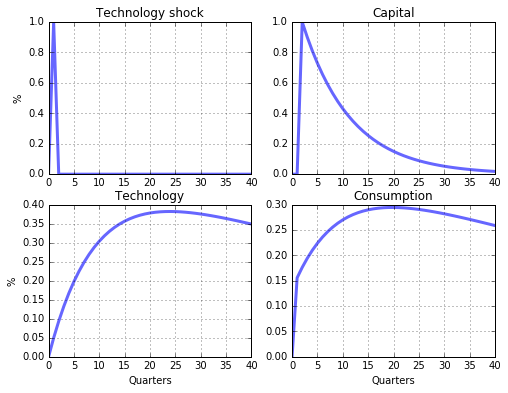

In [5]:
# Construct impulse responses
model.impulse(T=41,t0=1,shock=None)

# Shift the a(t) impulse response series back one period and trim end off all simulated series
model.irs['eA']['a'] = ls.shift(model.irs['eA']['a'],direction='backward')
model.irs['eA'] = ls.trim(model.irs['eA'],lengthEnd=1)

# Plot
figure = plt.figure(figsize=(8,6))
ax = figure.add_subplot(2,2,1)
ax.plot(100*model.irs['eA']['eA'],lw=3,alpha=0.6)
ax.set_title('Technology shock')
ax.set_ylabel('%')
ax.grid()

ax = figure.add_subplot(2,2,2)
ax.plot(100*model.irs['eA']['k'],lw=3,alpha=0.6)
ax.set_title('Capital')
ax.grid()

ax = figure.add_subplot(2,2,3)
ax.plot(100*model.irs['eA']['a'],lw=3,alpha=0.6)
ax.set_title('Technology')
ax.set_xlabel('Quarters')
ax.set_ylabel('%')
ax.grid()

ax = figure.add_subplot(2,2,4)
ax.plot(100*model.irs['eA']['c'],lw=3,alpha=0.6)
ax.set_title('Consumption')
ax.set_xlabel('Quarters')
ax.grid()

Apparently the model as-is exhibits an extraordinarily high degree of persistence.

### Stochastic simulation

Finally, the `model` variable has a method called `stochSim()` that is used to generate stochastic simulations of the endogenous variables to each eogenous shock variabe. Input the number of periods to simulate, the number of initial periods to drop, and the covariance matrix for the exogenous shocks.

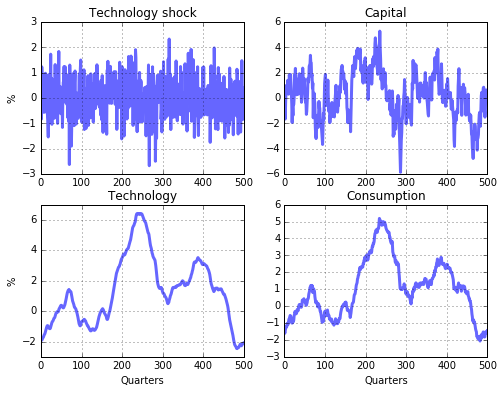

In [6]:
# Create the simulation
model.stochSim(T=500,dropFirst=1000,covMat=[[6e-05]])

# Adjust
model.sims['a'] = ls.shift(model.sims['a'],direction='backward')
model.sims['a'] = ls.trim(model.sims['a'],lengthEnd=1)

# Plot
figure = plt.figure(figsize=(8,6))
ax = figure.add_subplot(2,2,1)
ax.plot(100*model.sims['eA'],lw=3,alpha=0.6)
ax.set_title('Technology shock')
ax.set_ylabel('%')
ax.grid()

ax = figure.add_subplot(2,2,2)
ax.plot(100*model.sims['k'],lw=3,alpha=0.6)
ax.set_title('Capital')
ax.grid()

ax = figure.add_subplot(2,2,3)
ax.plot(100*model.sims['a'],lw=3,alpha=0.6)
ax.set_title('Technology')
ax.set_xlabel('Quarters')
ax.set_ylabel('%')
ax.grid()

ax = figure.add_subplot(2,2,4)
ax.plot(100*model.sims['c'],lw=3,alpha=0.6)
ax.set_title('Consumption')
ax.set_xlabel('Quarters')
ax.grid()

As was apparent from the impulse responses, the basic RBC model displays a high-degree of persistence.

## Example 2: A real business cyle (RBC) model *with* labor

The equilibrium conditions for a basic RBC model with endogenous labor supply are given by:

\begin{align}
C_t^{-\sigma} & = \beta E_t \left[C_{t+1}^{-\sigma}(\alpha A_{t+1} K_{t+1}^{\alpha-1}N_t^{1-\alpha} + 1 - \delta)\right]\\
C_t^{-\sigma}(1-\alpha) A_t K^{\alpha}_tN^{-\alpha}_t & = N^{\varphi}_t\\
C_t + K_{t+1} & = A_t K_t^{\alpha} + (1-\delta)K_t\\
\log A_t & = \rho_a \log A_{t-1} + \epsilon_t
\end{align}

In the nonstochastic steady state, we have:

\begin{align}
C^{-\sigma}(1-\alpha)AK^{\alpha} & = N^{\alpha + \varphi}\\
\beta^{-1} + \delta - 1 & = \alpha A K^{\alpha-1}N^{1-\alpha}\\
C & = AK^{\alpha} - \delta K
\end{align}

Given values for the parameters of the model, steady state values of capital and consumption are easily computed.

### The log-linearized model

The log-linear equilibrium conditions of the RBC model are:
\begin{align}
-\sigma \hat{c}_t & = -\sigma E_t\hat{c}_{t+1} + \alpha(\alpha - 1)\beta A K^{\alpha -1} \hat{k}_{t+1} + \alpha\beta A K^{\alpha -1} \rho_a\hat{a}_t\\
-\sigma  \hat{c}_t + \hat{a}_t + \alpha\hat{k}_t - \alpha \hat{n}_t & = \varphi \hat{n}_t\\
\frac{C}{K}\hat{c}_t + \hat{k}_{t+1} & = \left[\alpha A K^{\alpha -1} + 1-\delta \right] \hat{k}_t + A K^{\alpha -1}\hat{a}_t\\
\hat{a}_t & = \rho_a \hat{a}_{t-1} + \epsilon_t
\end{align}

### Writing the model in the required format

We need to write the model in the following form:

\begin{align}
A E_t\left[ x_{t+1} \right] & = B x_t + C Z_t,
\end{align}

with $X_t = [k_t; u_t]$ and where $k_t$ is a vector of predetermined (state) variables and $u_t$ is a vector 
of nonpredetermined (forward-looking) variables. So we need to determine what are the state variables and what are the forward-looking variables and then the contents of the matrices $A$, $B$, and $C$. Set $k_t = [\hat{a}_{t-1}\hat{k}_t]'$ and $u_t = [\hat{c}_t,\hat{n}_t]$ so that:

\begin{align}
x_t = \left[\begin{array} \hat{a}_{t-1} \\ \hat{k}_t \\ \hat{c}_t \\ \hat{n}_t \end{array}\right]
\end{align}

and:

\begin{align}
z_t = \left[\epsilon_t\right].
\end{align}

Then the matrices $A$, $B$, and $C$ are given by:

\begin{align}
A & = \left[\begin{matrix} 1 & 0 & 0 & 0 \\
\rho_a \alpha \beta A K^{\alpha-1} N^{1-\alpha} & \alpha(\alpha-1)\beta A K^{\alpha-1}N^{1-\alpha} & -\sigma & \alpha (1-\alpha) \beta A K^{\alpha-1} N^{1-\alpha}\\
-A K^{\alpha} N^{1-\alpha} & K & 0 & 0\\
1 & 0 & 0 & 0\end{matrix}\right],
\end{align}

\begin{align}
B & = \left[\begin{matrix}
0 & -\alpha & \sigma & (\alpha+\varphi) \\
0 & 0 & -\sigma & 0 \\
0 & (\alpha A K^{\alpha} N^{1-\alpha}+(1-\delta)K) & -C & (1-\alpha) A K^{\alpha} N^{1-\alpha} \\
\rho_a & 0 & 0 & 0
\end{matrix}\right],
\end{align}

and

\begin{align}
C & = \left[\begin{matrix}
0\\
0\\
0\\
1
\end{matrix}\right]
\end{align}

Again, note that the program will return a solution for $a_{t-1}$ and not $a_t$.

In [7]:
# Input model parameters
alpha = 0.35
beta = 0.99
delta  = 0.025
rhoa= 0.9
sigma= 1
phi = 0.5
A= 1

# Steady state solution
psi1 = (alpha*A/(beta**-1+delta-1))**(1/(1-alpha))
psi2 = (1/(1-alpha)/A/psi1**alpha)**(-1/sigma)

N = (psi2/(A*psi1**alpha-delta*psi1))**(sigma/(phi+sigma))
K = N*psi1
C = psi2*N**(-phi/sigma)

# Verify the steady state solution
print(C**-sigma*(1-alpha)*A*K**alpha-N**(alpha+phi))
print(beta**-1+delta-1 -alpha*A*K**(alpha-1)*N**(1-alpha))
print(C-A*K**alpha*N**(1-alpha) + delta*K)

-1.1102230246251565e-16
-1.3877787807814457e-17
1.1102230246251565e-16


In [8]:
# Input the matrix values for the solution
a11,a12,a13,a14 = 1,0,0,0
a21,a22,a23,a24 = rhoa*alpha*beta*A*K**(alpha-1)*N**(1-alpha),alpha*(alpha-1)*beta*A*K**(alpha-1)*N**(1-alpha),-sigma,alpha*(1-alpha)*beta*A*K**(alpha-1)*N**(1-alpha)
a31,a32,a33,a34 = -A*K**alpha*N**(1-alpha),K,0,0
a41,a42,a43,a44 = 1,0,0,0

b11,b12,b13,b14 = 0,-alpha,sigma,(alpha+phi)
b21,b22,b23,b24 = 0,0,-sigma,0
b31,b32,b33,b34 = 0, (alpha*A*K**alpha*N**(1-alpha)+(1-delta)*K), -C,(1-alpha)*A*K**alpha*N**(1-alpha)
b41,b42,b43,b44 = rhoa, 0, 0, 0

c11 = 0
c21 = 0
c31 = 0
c41 = 1

# Form the required matrices
a = [[a11, a12, a13, a14], [a21, a22, a23, a24], [a31, a32, a33, a34], [a41, a42, a43, a44]]
b = [[b11, b12, b13, b14], [b21, b22, b23, b24], [b31, b32, b33, b34], [b41, b42, b43, b44]]
c = [[c11],[c21],[c31],[c41]]


# The exogenous shock process has no autocorrelation
rho = [[0.0]]

# The model has two predetermined variables
nk = 2

# Solve the model
model = ls.klein(a,b,c,rho,nk,endoNames=['a','k','c','n'],exoNames=['eA'])

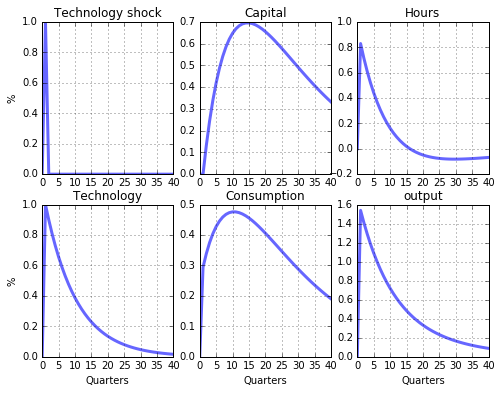

In [9]:
# Construct impulse responses
model.impulse(T=41,t0=1,shock=None)

# Shift the a(t) impulse response series back one period and trim end off all simulated series
model.irs['eA']['a'] = ls.shift(model.irs['eA']['a'],direction='backward')
model.irs['eA'] = ls.trim(model.irs['eA'],lengthEnd=1)

# Plot
figure = plt.figure(figsize=(8,6))
ax = figure.add_subplot(2,3,1)
ax.plot(100*model.irs['eA']['eA'],lw=3,alpha=0.6)
ax.set_title('Technology shock')
ax.set_ylabel('%')
ax.grid()

ax = figure.add_subplot(2,3,2)
ax.plot(100*model.irs['eA']['k'],lw=3,alpha=0.6)
ax.set_title('Capital')
ax.grid()

ax = figure.add_subplot(2,3,3)
ax.plot(100*model.irs['eA']['n'],lw=3,alpha=0.6)
ax.set_title('Hours')
ax.grid()

ax = figure.add_subplot(2,3,4)
ax.plot(100*model.irs['eA']['a'],lw=3,alpha=0.6)
ax.set_title('Technology')
ax.set_xlabel('Quarters')
ax.set_ylabel('%')
ax.grid()

ax = figure.add_subplot(2,3,5)
ax.plot(100*model.irs['eA']['c'],lw=3,alpha=0.6)
ax.set_title('Consumption')
ax.set_xlabel('Quarters')
ax.grid()

ax = figure.add_subplot(2,3,6)
ax.plot(100*(model.irs['eA']['a'] + alpha*model.irs['eA']['k'] + (1-alpha)*model.irs['eA']['n']),lw=3,alpha=0.6)
ax.set_title('output')
ax.set_xlabel('Quarters')
ax.grid()

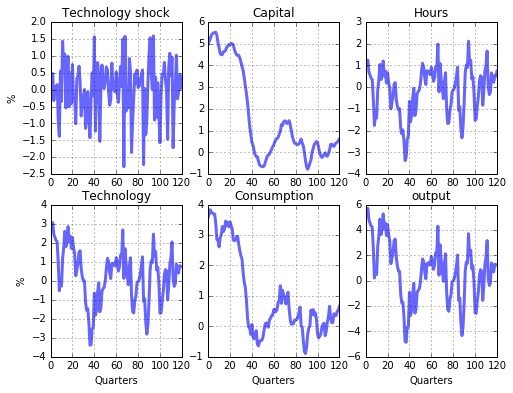

In [10]:
# Create the simulation
model.stochSim(T=120,dropFirst=1000,covMat=[[6e-05]])

# Adjust
model.sims['a'] = ls.shift(model.sims['a'],direction='backward')
model.sims['a'] = ls.trim(model.sims['a'],lengthEnd=1)

# Plot
figure = plt.figure(figsize=(8,6))
ax = figure.add_subplot(2,3,1)
ax.plot(100*model.sims['eA'],lw=3,alpha=0.6)
ax.set_title('Technology shock')
ax.set_ylabel('%')
ax.grid()

ax = figure.add_subplot(2,3,2)
ax.plot(100*model.sims['k'],lw=3,alpha=0.6)
ax.set_title('Capital')
ax.grid()

ax = figure.add_subplot(2,3,3)
ax.plot(100*model.sims['n'],lw=3,alpha=0.6)
ax.set_title('Hours')
ax.grid()

ax = figure.add_subplot(2,3,4)
ax.plot(100*model.sims['a'],lw=3,alpha=0.6)
ax.set_title('Technology')
ax.set_xlabel('Quarters')
ax.set_ylabel('%')
ax.grid()

ax = figure.add_subplot(2,3,5)
ax.plot(100*model.sims['c'],lw=3,alpha=0.6)
ax.set_title('Consumption')
ax.set_xlabel('Quarters')
ax.grid()

ax = figure.add_subplot(2,3,6)
ax.plot(100*(model.sims['a'] + alpha*model.sims['k'] + (1-alpha)*model.sims['n']),lw=3,alpha=0.6)
ax.set_title('output')
ax.set_xlabel('Quarters')
ax.grid()

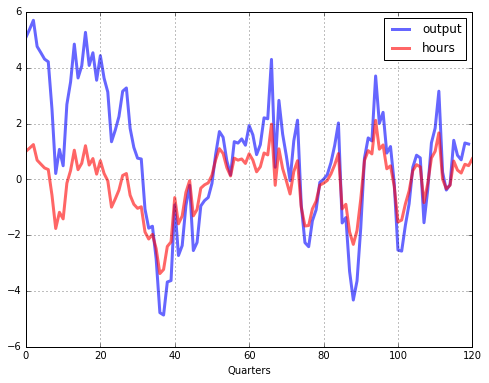

In [11]:
# Replicate Figure 15.3 from Prescott (1986)
figure = plt.figure(figsize=(8,6))
ax = figure.add_subplot(1,1,1)
ax.plot(100*(model.sims['a'] + alpha*model.sims['k'] + (1-alpha)*model.sims['n']),lw=3,alpha=0.6)
ax.plot(100*model.sims['n'],'r',lw=3,alpha=0.6)
ax.legend(['output','hours'],)
ax.set_xlabel('Quarters')
ax.grid()

## Example 3: A New-Keynesian business cycle model

Consider the new-Keynesian model from Walsh (2010), chapter 8.

\begin{align}
x_t & = E_tx_{t+1} - \sigma^{-1} (i_t - E_t\pi_{t+1}) + g_t\\
\pi_t & = \beta  E_t\pi_{t+1} + \kappa  x_t + u_t\\
i_t & = \phi_x  x_t + \phi_{\pi}  \pi_t + v_t\\
r_t & = i_t - E_t\pi_{t+1}\\
g_t & = \rho_g g_{t-1} + \epsilon_t^g\\
u_t & = \rho_u u_{t-1} + \epsilon_t^u\\
v_t & = \rho_v v_{t-1} + \epsilon_t^v
\end{align}

where $x_t$ is the output gap, $\pi_t$ is the quarterly rate of inflation between $t-1$ and $t$, $i_t$ is the nominal interest rate on funds moving between perid $t$ and $t+1$, $r_t$ is the real interest rate, $g_t$ is the exogenous component of demand, $u_t$ is an exogenous component of inflation, and $v_t$ is the exogenous component of monetary policy. 

There are two ways to think about the exogenous variables $g_t$, $u_t$, and $v_t$ when preparing to solve the model. One option is to think of them as endogenous state variables that are driven by serially correlated exogenous shocks. The other is to think about $g_t$, $u_t$, and $v_t$ as being serially correlated exogenous shocks. Both are reasonable, but the latter is easier becuase it reduces the sizes of the matrices $A$ and $B$ so the model is easier to code without error.

### Approach 1

Treating the variables $g_t$, $u_t$, and $v_t$ as endogenous state variables that are driven by serially correlated exogenous shocks leads to the following definitions of the vector $x_t$ and the matrices $A$, $B$, and $C$:

\begin{align}
x_t = \left[\begin{matrix}
\hat{g}_{t-1}\\
\hat{u}_{t-1}\\
\hat{v}_{t-1}\\
\hat{i}_t\\
\hat{r}_t\\
\hat{x}_t\\
\hat{\pi}_t
\end{matrix}\right]
\end{align}

and:

\begin{align}
A = \left[\begin{matrix}
1 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 1 & \sigma^{-1}\\
0 & 1 & 0 & 0 & 0 & 0 & \beta\\
0 & 0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 1
\end{matrix}\right],
\end{align}

\begin{align}
B = \left[\begin{matrix}
\rho_g & 0 & 0 & 0 & 0 & 0 & 0\\
0 & \rho_u & 0 & 0 & 0 & 0 & 0\\
0 & 0 & \rho_v & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \sigma^{-1} & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & -\kappa & 1\\
0 & 0 & 0 & 1 & 0 & -\phi_x & -\phi_{\pi}\\
0 & 0 & 0 & 1 & -1 & 0 & 0
\end{matrix}\right],
\end{align}

and

\begin{align}
C = \left[\begin{matrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1\\
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0
\end{matrix}\right].
\end{align}

With these definitions, the model is prepared to be solved. Note that the model will solve for $g_{t-1}$, $u_{t-1}$, and $v_{t-1}$ so keep this in mind.

In [12]:
# Input model parameters
beta = 0.99
sigma= 1
eta  = 1
omega= 0.8
kappa= (sigma+eta)*(1-omega)*(1-beta*omega)/omega

rhor = 0.9
phipi= 1.5
phix = 0

rhog = 0.5
rhou = 0.5
rhov = 0.5

# Input the matrix values for the solution
a = [
    [1,0,0,0,0,0,0],
    [0,1,0,0,0,0,0],
    [0,0,1,0,0,0,0],
    [1,0,0,0,0,1,sigma**-1],
    [0,1,0,0,0,0,beta],
    [0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1]
]

b = [
    [rhog,0,0,0,0,0,0],
    [0,rhou,0,0,0,0,0],
    [0,0,rhov,0,0,0,0],
    [0,0,0,sigma**-1,0,1,0],
    [0,0,0,0,0,-kappa,1],
    [0,0,0,1,0,-phix,-phipi],
    [0,0,0,1,-1,0,0]
]

c = [
    [1,0,0],
    [0,1,0],
    [0,0,1],
    [0,0,0],
    [0,0,0],
    [0,0,0],
    [0,0,0],
    ]

# The exogenous shocks are serially uncorrelated
rho = np.zeros([3,3])

# The model as written has three endogenous state variables
nk = 3

# Solve the model
model = ls.klein(a,b,c,rho,nk,endoNames=['g','u','v','i','r','x','pi'],exoNames=['eg','eu','ev'])

In [13]:
# Construct impulse responses
model.impulse(T=13,t0=1,shock=[0.01,0.01,1])

# Shift the g(t), u(t), and v(t) impulse response series back one period and trim end off all simulated series
model.irs['eg']['g'] = ls.shift(model.irs['eg']['g'],direction='backward')
model.irs['eg'] = ls.trim(model.irs['eg'],lengthEnd=1)

model.irs['eu']['u'] = ls.shift(model.irs['eu']['u'],direction='backward')
model.irs['eu'] = ls.trim(model.irs['eu'],lengthEnd=1)

model.irs['ev']['v'] = ls.shift(model.irs['ev']['v'],direction='backward')
model.irs['ev'] = ls.trim(model.irs['ev'],lengthEnd=1)

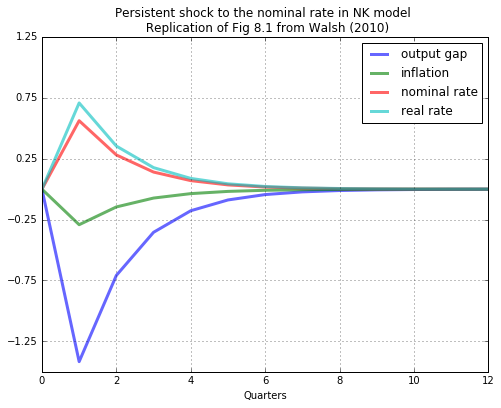

In [14]:
# Replicate Figure 8.1 from Walsh (2010)

# Variable containing the name of the shock and the simulated variable to be selected
whichShock = ['ev','v']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot(model.irs[whichShock[0]]['x'],lw=3,alpha=0.6)
ax.plot(model.irs[whichShock[0]]['pi'],lw=3,alpha=0.6)
ax.plot(model.irs[whichShock[0]]['i'],lw=3,alpha=0.6)
ax.plot(model.irs[whichShock[0]]['r'],lw=3,alpha=0.6)
ax.set_title('Persistent shock to the nominal rate in NK model \n Replication of Fig 8.1 from Walsh (2010)')
ax.set_xlabel('Quarters')
ax.set_yticks([-1.25,-0.75,-0.25,0.25,0.75,1.25])
ax.legend(['output gap','inflation','nominal rate','real rate'])
ax.grid()

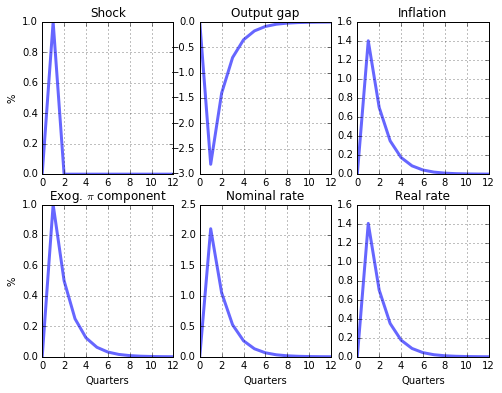

In [15]:
# Plot impulse responses to an inflation shock

whichShock = ['eu','u']

# Plot
figure = plt.figure(figsize=(8,6))
ax = figure.add_subplot(2,3,1)
ax.plot(100*model.irs[whichShock[0]][whichShock[0]],lw=3,alpha=0.6)
ax.set_title('Shock')
ax.set_ylabel('%')
ax.grid()

ax = figure.add_subplot(2,3,2)
ax.plot(100*model.irs[whichShock[0]]['x'],lw=3,alpha=0.6)
ax.set_title('Output gap')
ax.grid()

ax = figure.add_subplot(2,3,3)
ax.plot(100*model.irs[whichShock[0]]['pi'],lw=3,alpha=0.6)
ax.set_title('Inflation')
ax.grid()

ax = figure.add_subplot(2,3,4)
ax.plot(100*model.irs[whichShock[0]][whichShock[1]],lw=3,alpha=0.6)
ax.set_title('Exog. $\pi$ component')
ax.set_xlabel('Quarters')
ax.set_ylabel('%')
ax.grid()

ax = figure.add_subplot(2,3,5)
ax.plot(100*model.irs[whichShock[0]]['i'],lw=3,alpha=0.6)
ax.set_title('Nominal rate')
ax.set_xlabel('Quarters')
ax.grid()

ax = figure.add_subplot(2,3,6)
ax.plot(100*model.irs[whichShock[0]]['r'],lw=3,alpha=0.6)
ax.set_title('Real rate')
ax.set_xlabel('Quarters')
ax.grid()

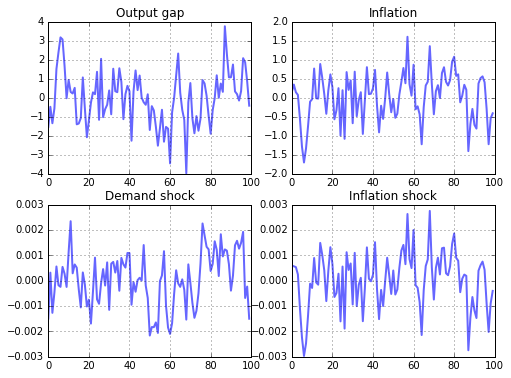

In [16]:
# Create a stochastic simulation of the economy to demand and supply shocks
model.stochSim(T=100,dropFirst=1000,covMat=[[0.000001,0,0],[0,0.000001,0],[0,0,0]])

# Adjust for the time difference of the exogenous series
model.sims['g'] = ls.shift(model.sims['g'],direction='backward')
model.sims['u'] = ls.shift(model.sims['u'],direction='backward')
model.sims['v'] = ls.shift(model.sims['v'],direction='backward')
model.sims = ls.trim(model.sims,lengthEnd=1)

# Plot the simulation
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(2,2,1)
ax.plot(4*100*model.sims['x'],lw=2,alpha=0.6)
ax.set_title('Output gap')
ax.grid()
ax = fig.add_subplot(2,2,2)
ax.plot(4*100*model.sims['pi'],lw=2,alpha=0.6)
ax.set_title('Inflation')
ax.grid()
ax = fig.add_subplot(2,2,3)
ax.plot(model.sims['g'],lw=2,alpha=0.6)
ax.set_title('Demand shock')
ax.grid()
ax = fig.add_subplot(2,2,4)
ax.plot(model.sims['u'],lw=2,alpha=0.6)
ax.set_title('Inflation shock')
ax.grid()

### Approach 2

Treat the variables $g_t$, $u_t$, and $v_t$ as serially correlated exogenous forcing variables. Doing so will reduce the size of the vector $x_t$, will make the matrices $A$, $B$, and $C$ easier to write, but the simulation routines will not reutrn values for the underlying i.i.d. shock processes. The vector $x_t$ and the matrices $A$, $B$, and $C$ are now given by:

\begin{align}
x_t = \left[\begin{matrix}
\hat{\imath}_t\\
\hat{r}_t\\
\hat{x}_t\\
\hat{\pi}_t
\end{matrix}\right]
\end{align}

and:

\begin{align}
A = \left[\begin{matrix}
0 & 0 & 1 & \sigma^{-1}\\
0 & 0 & 0 & \beta\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 1
\end{matrix}\right],
\end{align}

\begin{align}
B = \left[\begin{matrix}
\sigma^{-1} & 0 & 1 & 0\\
0 & 0 & -\kappa & 1\\
1 & 0 & -\phi_x & -\phi_{\pi}\\
1 & -1 & 0 & 0
\end{matrix}\right],
\end{align}

and

\begin{align}
C = \left[\begin{matrix}
-1 & 0 & 0\\
0 & -1 & 0\\
0 & 0 & -1\\
0 & 0 & 0
\end{matrix}\right].
\end{align}

Now, instead of specifying the coefficients of autocorrelation in the matrix $B$, we have to specify them in a matrix called `rho`:

\begin{align}
\rho = \left[\begin{matrix}
\rho_g & 0 & 0\\
0 & \rho_u & 0\\
0 & 0 & \rho_v
\end{matrix}\right].
\end{align}

In [17]:
# Input model parameters
beta = 0.99
sigma= 1
eta  = 1
omega= 0.8
kappa= (sigma+eta)*(1-omega)*(1-beta*omega)/omega

rhor = 0.9
phipi= 1.5
phix = 0

rhog = 0.5
rhou = 0.5
rhov = 0.5

# Input the matrix values for the solution
a = [
    [0,0,1,0/sigma],
    [0,0,0,beta],
    [0,0,0,0],
    [0,0,0,1]
]

b = [
    [1/sigma,0,1,0],
    [0,0,-kappa,1],
    [1,0,-phix,-phipi],
    [1,-1,0,0]
]

c = [
    [-1,0,0],
    [0,-1,0],
    [0,0,-1],
    [0,0,0]
    ]

# Specify the matrix of autocorrelation for the exogenous driving processes
rho = [[rhog,0,0],[0,rhou,0],[0,0,rhov]]

# Here, the model has no state variables
nk = 0

# Solve the model
model = ls.klein(a,b,c,rho,nk,endoNames=['i','r','x','pi'],exoNames=['eg','eu','ev'])

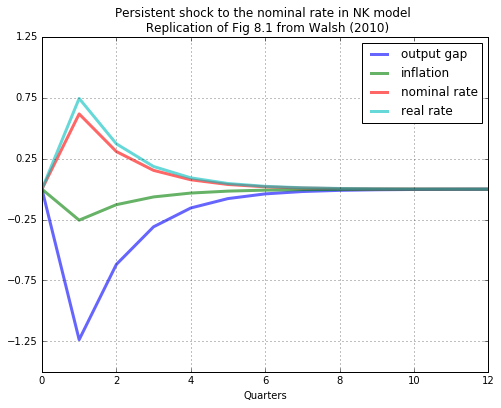

In [18]:
# Construct impulse responses
model.impulse(T=12,t0=1,shock=[1,1,1])


# Re-replicate the Figure 8.1 from Walsh (2010)
whichShock = ['ev','v']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot(model.irs[whichShock[0]]['x'],lw=3,alpha=0.6)
ax.plot(model.irs[whichShock[0]]['pi'],lw=3,alpha=0.6)
ax.plot(model.irs[whichShock[0]]['i'],lw=3,alpha=0.6)
ax.plot(model.irs[whichShock[0]]['r'],lw=3,alpha=0.6)
ax.set_title('Persistent shock to the nominal rate in NK model \n Replication of Fig 8.1 from Walsh (2010)')
ax.set_xlabel('Quarters')
ax.set_yticks([-1.25,-0.75,-0.25,0.25,0.75,1.25])
ax.legend(['output gap','inflation','nominal rate','real rate'])
ax.grid()
